In [146]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def generate_synthetic_data(sigma):
    np.random.seed(0)
    
    mean_a = np.array([-1, -1])
    cov_a  = sigma * np.array([[2, 0.5], [0.5, 1]])
    
    mean_b = np.array([1, -1])
    cov_b  = sigma * np.array([[1, -0.5], [-0.5, 2]])
    
    mean_c = np.array([0, 1])
    cov_c  = sigma * np.array([[1, 0], [0, 2]])
    
    data_a = np.random.multivariate_normal(mean_a, cov_a, 100)
    data_b = np.random.multivariate_normal(mean_b, cov_b, 100)
    data_c = np.random.multivariate_normal(mean_c, cov_c, 100)
    
    synthetic_data = np.concatenate((data_a, data_b, data_c))
    return synthetic_data                

In [11]:
sigma_values = [0.5, 1, 2, 4, 8]
datasets = [generate_synthetic_data(sigma) for sigma in sigma_values]
print(datasets[0].shape)

(300, 2)


In [12]:
# Implement K-means clustering
def kmeans_pp_init(data, k):
    # Initialize the centroids list with the first randomly chosen data point
    centroids = [data[np.random.choice(len(data))]]
    
    for i in range(1, k):
        # Calculate the squared distances of each data point to the nearest existing centroid
        distances = np.array([min([np.linalg.norm(x - c) ** 2 for c in centroids]) for x in data])
        
        # Choose the next centroid with probability proportional to the squared distance
        probabilities = distances / distances.sum()
        centroids.append(data[np.random.choice(len(data), p=probabilities)])
        
    return np.array(centroids)


def kmeans(data, k, max_iters=100):
    # Initialize centroids using k-means++ initialization
    centroids = kmeans_pp_init(data, k)
    
    for i in range(max_iters):
        # Assign data points to the nearest centroid
        labels = np.argmin(np.linalg.norm(data[:, np.newaxis] - centroids, axis=2), axis=1)
        
        # Update centroids
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
        
        if np.all(centroids == new_centroids):
            break
            
        centroids = new_centroids
        
    return centroids, labels  

In [52]:
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import accuracy_score

objective_values = []
accuracies = []
for i, sigma in enumerate(sigma_values):
    k = 3
    data = datasets[i]
    centroids, labels = kmeans(data, k)
    
    # Calculate the K-means objective value
    objective_value = sum(np.linalg.norm(data[labels == j] - centroids[j])**2 for j in range(k))
    objective_values.append(objective_value)
    
    # Compute clustering accuracy by mapping cluster centers to the actual distributions
    true_centers = np.array([[-1, -1], [1, -1], [0, 1]])
    mapping = pairwise_distances_argmin_min(centroids, true_centers, axis=1)[0]
    
    mapped_labels = np.array([mapping[label] for label in labels])
    true_labels = np.hstack((np.zeros(100), np.ones(100), 2 * np.ones(100)))

    accuracy = accuracy_score(true_labels, mapped_labels)
    accuracies.append(accuracy)
    
    print(f"σ = {sigma}, K-means objective = {objective_value}, accuracy = {accuracy:.2f}")

σ = 0.5, K-means objective = 323.6705853682555, accuracy = 0.79
σ = 1, K-means objective = 531.2037446107713, accuracy = 0.69
σ = 2, K-means objective = 929.8873442088341, accuracy = 0.59
σ = 4, K-means objective = 1706.2090711956348, accuracy = 0.53
σ = 8, K-means objective = 3280.873931326597, accuracy = 0.49


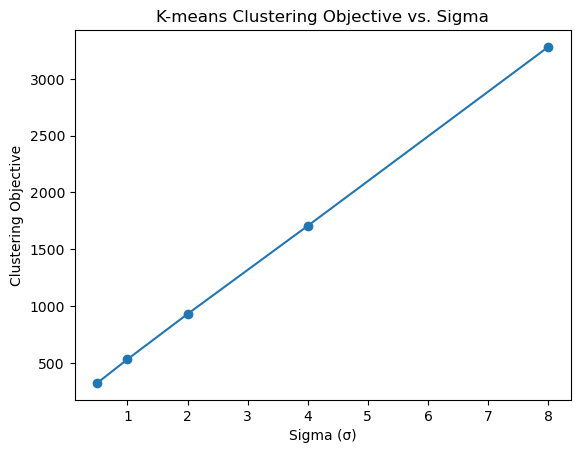

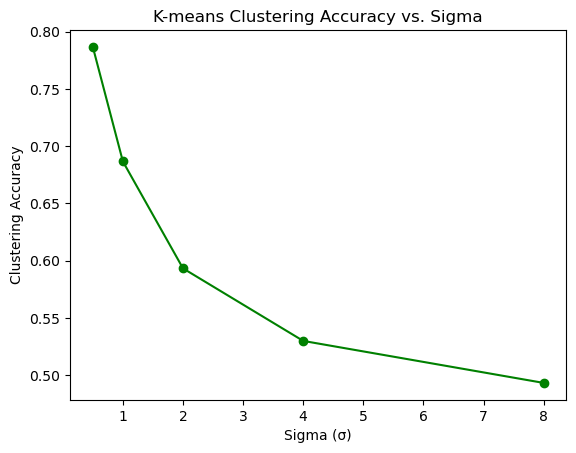

In [338]:
plt.plot(sigma_values, objective_values, marker='o')
plt.xlabel('Sigma (σ)')
plt.ylabel('Clustering Objective')
plt.title('K-means Clustering Objective vs. Sigma')
plt.savefig('kmeans-obj.png')
plt.show()

plt.plot(sigma_values, accuracies, marker='o', color='g')
plt.xlabel('Sigma (σ)')
plt.ylabel('Clustering Accuracy')
plt.title('K-means Clustering Accuracy vs. Sigma')
plt.savefig('kmeans-acc.png')
plt.show()

In [360]:
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, n_components, max_iter=100, n_init=10, tol=1e-3, random_state=None):
        self.n_components = n_components
        self.max_iter = max_iter
        self.n_init = n_init
        self.tol = tol
        self.random_state = random_state
        self.best_gmm = None
        self.best_labels = None
        self.best_ll = -np.inf

    def initialize_with_kmeans(self, data):
        from sklearn.cluster import KMeans

        kmeans = KMeans(n_clusters=self.n_components, random_state=self.random_state)
        kmeans.fit(data)
        self.means = kmeans.cluster_centers_
        self.covs = [np.cov(data[kmeans.labels_ == i].T) for i in range(self.n_components)]
        self.weights = np.array([np.mean(kmeans.labels_ == i) for i in range(self.n_components)])

    def initialize_randomly(self, data):
        np.random.seed(self.random_state)
        n_samples, _ = data.shape
        self.means = data[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covs = [np.eye(data.shape[1]) for _ in range(self.n_components)]
        self.weights = np.full(self.n_components, 1.0 / self.n_components)

    def fit(self, data):
        for _ in range(self.n_init):
            if self.random_state is not None:
                np.random.seed(self.random_state)
            self.initialize_with_kmeans(data)
            ll = self.expectation_maximization(data)
            if ll > self.best_ll:
                self.best_ll = ll
                self.best_gmm = self
                self.best_labels = self.expectation(data)

    def expectation(self, data):
        log_likelihoods = self.compute_log_likelihood(data)
        return np.argmax(log_likelihoods, axis=1)

    def compute_log_likelihood(self, data):
        log_likelihoods = np.zeros((data.shape[0], self.n_components))
        for i in range(self.n_components):
            mvn = multivariate_normal(self.means[i], self.covs[i])
            log_likelihoods[:, i] = np.log(self.weights[i]) + mvn.logpdf(data)
        return log_likelihoods

    def expectation_maximization(self, data):
        for _ in range(self.max_iter):
            # E-step
            responsibilities = self.compute_responsibilities(data)
            # M-step
            self.update_parameters(data, responsibilities)
            # Calculate the log likelihood
            ll = self.calculate_log_likelihood(data)
            # Check for convergence
            if np.abs(ll - self.best_ll) < self.tol:
                break
        return ll

    def compute_responsibilities(self, data):
        log_likelihoods = self.compute_log_likelihood(data)
        log_likelihoods = log_likelihoods - np.max(log_likelihoods, axis=1)[:, np.newaxis]  # Normalize for numerical stability
        unnormalized_responsibilities = np.exp(log_likelihoods)
        responsibilities = unnormalized_responsibilities / np.sum(unnormalized_responsibilities, axis=1)[:, np.newaxis]
        return responsibilities

    def update_parameters(self, data, responsibilities):
        total_responsibilities = np.sum(responsibilities, axis=0)
        self.weights = total_responsibilities / data.shape[0]
        for i in range(self.n_components):
            self.means[i] = np.sum(responsibilities[:, i][:, np.newaxis] * data, axis=0) / total_responsibilities[i]
            diff = data - self.means[i]
            self.covs[i] = np.dot((diff * responsibilities[:, i][:, np.newaxis]).T, diff) / total_responsibilities[i]

    def calculate_log_likelihood(self, data):
        log_likelihoods = self.compute_log_likelihood(data)
        log_likelihood = np.sum(np.log(np.sum(np.exp(log_likelihoods), axis=1)))
        return log_likelihood


gmm_objective_values = []
gmm_accuracies = []

for i, sigma in enumerate(sigma_values):
    data = datasets[i]
    k = 3

    gmm = GMM(n_components=k, n_init=10, random_state=0)
    gmm.fit(data)
    labels = gmm.best_labels

    true_means = np.array([[-1, -1], [1, -1], [0, 1]])
    gmm_mapping = pairwise_distances_argmin_min(gmm.best_gmm.means, true_means, axis=1)[0]
    gmm_mapped_labels = np.array([gmm_mapping[label] for label in labels])

    # Calculate accuracy by comparing to the true labels
    gmm_accuracy = accuracy_score(true_labels, gmm_mapped_labels)
    gmm_accuracies.append(gmm_accuracy)

    objective = -gmm.best_ll
    gmm_objective_values.append(objective)

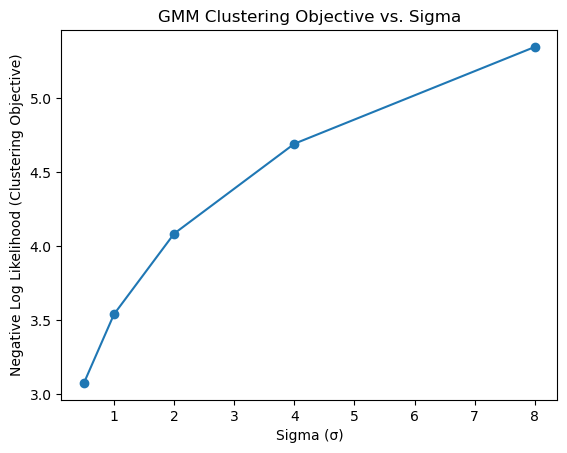

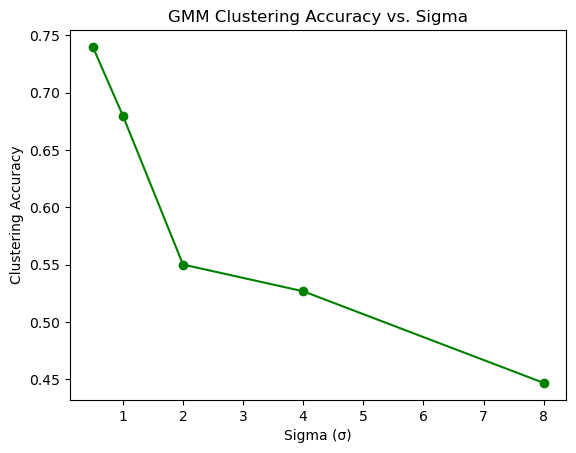

In [340]:
# if negative log-likelihood is averaged

# Plot the clustering objective against sigma
plt.plot(sigma_values, gmm_objective_values, marker='o')
plt.xlabel('Sigma (σ)')
plt.ylabel('Negative Log Likelihood (Clustering Objective)')
plt.title('GMM Clustering Objective vs. Sigma')
plt.savefig('gmm-obj.png')
plt.show()

# Plot the clustering accuracy against sigma
plt.plot(sigma_values, gmm_accuracies, marker='o', color='g')
plt.xlabel('Sigma (σ)')
plt.ylabel('Clustering Accuracy')
plt.title('GMM Clustering Accuracy vs. Sigma')
plt.savefig('gmm-acc.png')
plt.show()

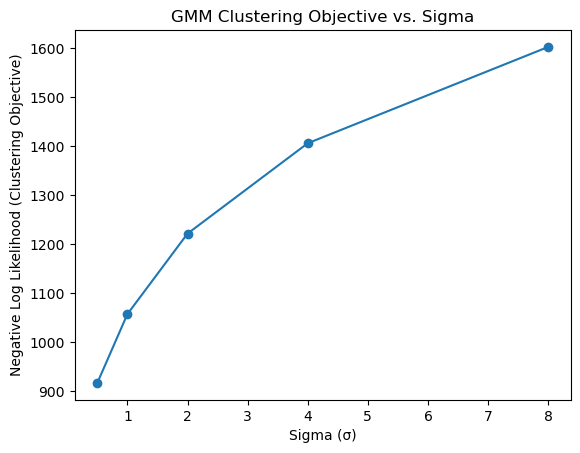

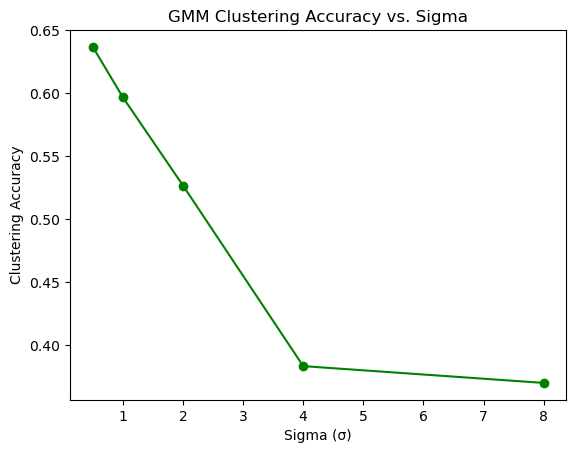

In [361]:
# if negative log-likelihood is not averaged

# Plot the clustering objective against sigma
plt.plot(sigma_values, gmm_objective_values, marker='o')
plt.xlabel('Sigma (σ)')
plt.ylabel('Negative Log Likelihood (Clustering Objective)')
plt.title('GMM Clustering Objective vs. Sigma')
# plt.savefig('gmm-obj.png')
plt.show()

# Plot the clustering accuracy against sigma
plt.plot(sigma_values, gmm_accuracies, marker='o', color='g')
plt.xlabel('Sigma (σ)')
plt.ylabel('Clustering Accuracy')
plt.title('GMM Clustering Accuracy vs. Sigma')
# plt.savefig('gmm-acc.png')
plt.show()

In [306]:
#Experiment 2.3

# Load the datasets
data_2D = np.loadtxt('data/data2D.csv', delimiter=',')
data_1000D = np.loadtxt('data/data1000D.csv', delimiter=',')

print(data_2D.shape)
print(data_1000D.shape)

(50, 2)
(500, 1000)


In [307]:
def buggy_pca(X, d):
    # Perform Buggy PCA by taking the SVD of X
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    V = Vt[:d, :].T  # Transpose to get the top d eigenvectors
    
    # projecting each data point onto these eigenvectors, effectively mapping each data point from the 
    # original high-dimensional space to a lower-dimensional space
    Z = np.dot(X, V)
    
    reconstructions = np.dot(Z, V.T)
    return Z, V, reconstructions

def demeaned_pca(X, d):
    mean = np.mean(X, axis=0)
    X_demeaned = X - mean
    Z, V, reconstructions_demeaned = buggy_pca(X_demeaned, d)
    reconstructions = reconstructions_demeaned + mean
    return Z, V, reconstructions

def normalized_pca(X, d):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_normalized = (X - mean) / std
    Z, V, reconstructions_normalized = buggy_pca(X_normalized, d)
    reconstructions = (reconstructions_normalized * std) + mean
    return Z, V, reconstructions

def calculate_reconstruction_error(original, reconstructed):
    error = np.sum(np.square(original - reconstructed)) / len(original)
    rounded_error = round(error, 6)
    return rounded_error

In [308]:
# For the 2D dataset, use d = 1
d_2D = 1
Z_b, V_b, rec_b = buggy_pca(data_2D, d_2D)
Z_d, V_d, rec_d = demeaned_pca(data_2D, d_2D)
Z_n, V_n, rec_n = normalized_pca(data_2D, d_2D)
print(rec_b.shape)

# Calculate reconstruction errors for 2D dataset
error_b = calculate_reconstruction_error(data_2D, rec_b)
error_d = calculate_reconstruction_error(data_2D, rec_d)
error_n = calculate_reconstruction_error(data_2D, rec_n)

print("Reconstruction errors:")
print("Buggy PCA:", error_b)
print("Demeaned PCA:", error_d)
print("Normalized PCA:", error_n)

(50, 2)
Reconstruction errors:
Buggy PCA: 0.886903
Demeaned PCA: 0.010006
Normalized PCA: 0.049472


In [309]:
def plot_reconstruction(X, rec, method_name):
    plt.scatter(X[:, 0], X[:, 1], label="Original Points", marker='o', facecolors='none', edgecolors='blue')
    plt.scatter(rec[:, 0], rec[:, 1], label="Reconstructed Points", c="red", marker='x')
    plt.title(f"{method_name} - 2D Dataset")
    plt.legend()

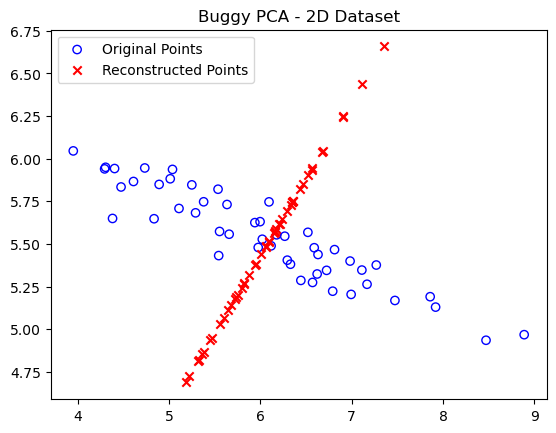

In [310]:
# Plot for Buggy PCA
plot_reconstruction(data_2D, rec_b, "Buggy PCA")
plt.savefig('buggy_pca.png')
plt.show()

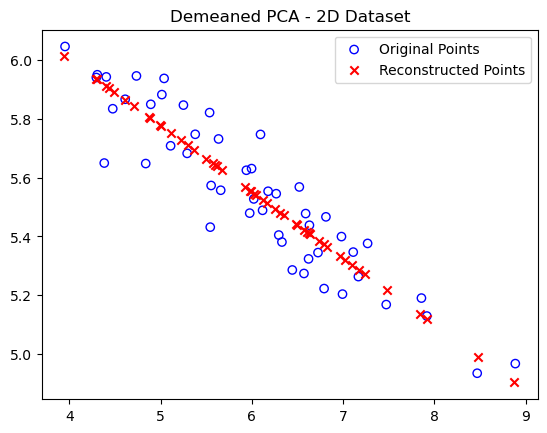

In [311]:
# Plot for Demeaned PCA
plot_reconstruction(data_2D, rec_d, "Demeaned PCA")
plt.savefig('demeaned_pca.png')
plt.show()

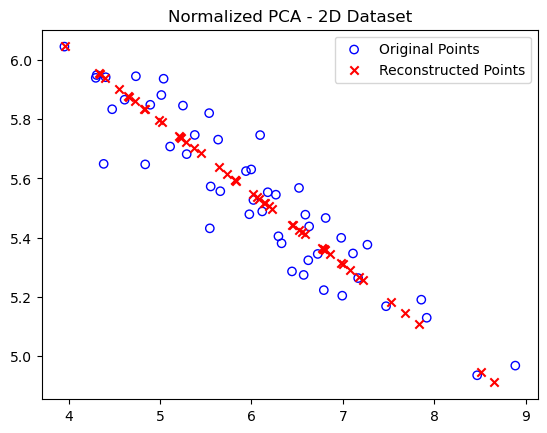

In [312]:
# Plot for Normalized PCA
plot_reconstruction(data_2D, rec_n, "Normalized PCA")
plt.savefig('normalized_pca.png')
plt.show()

In [302]:
# DRO
def dro(X, d):
    b = np.mean(X, axis=0)
    X_minus_b = X - b
    U, S, Vt = np.linalg.svd(X_minus_b, full_matrices=False)
    
    # Slice U, S, and V to get the reduced dimensions
    Ud = U[:, :d]
    Sd = np.diag(S[:d])
    Vd = Vt[:d, :]
    
    n = X.shape[0]  # Replace with the actual value of 'n'
    A = (1 / np.sqrt(n)) * np.dot(Sd, Vd).T
    
    Z = np.sqrt(n) * Ud
    reconstruction = np.add(np.dot(Z, A.T), b)
    
    return Z, (A, b), reconstruction

In [237]:
Z_dro, _, rec_dro = dro(data_2D, d_2D)

# Calculate reconstruction errors for 2D dataset
error_dro = calculate_reconstruction_error(data_2D, rec_dro)
print("DRO: ", error_dro)

[[-1.11806201]
 [ 0.25200327]]
DRO:  0.010006


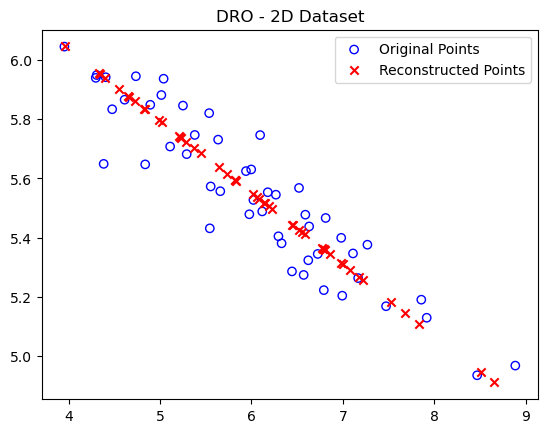

In [313]:
# Plot for DRO
plot_reconstruction(data_2D, rec_n, "DRO")
plt.savefig('dro.png')
plt.show()

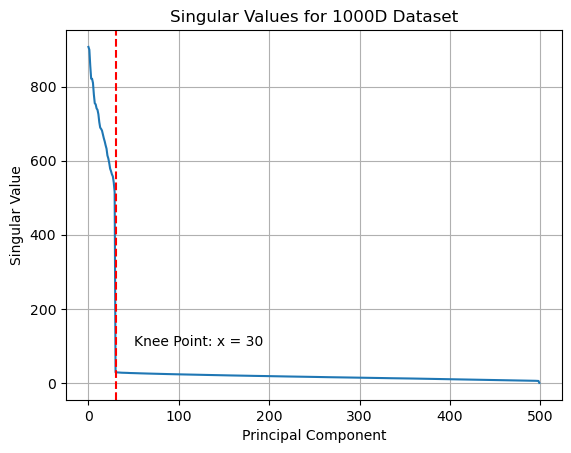

In [314]:
X = data_1000D
b = np.mean(X, axis=0)
X_minus_b = X - b

# For the 1000D dataset, analyze singular values to determine the appropriate 'd'
singular_values = np.linalg.svd(X_minus_b, full_matrices=False, compute_uv=False)

# Plot the singular values to find the 'knee point'plt.figure(figsize=(10, 5))
# plt.plot(S, marker='o')
plt.plot(singular_values)
plt.title("Singular Values for 1000D Dataset")
plt.xlabel("Principal Component")
plt.ylabel("Singular Value")
plt.grid(True)

knee_point_index = 30
# Plot a vertical line at the knee point
plt.axvline(x=knee_point_index, color='red', linestyle='--', label='Knee Point')
# plt.annotate(f'Knee Point: x = {knee_point_index}', xy=(knee_point_index, 30), xytext=(knee_point_index + 20, 70),
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', color='red'))
plt.annotate(f'Knee Point: x = {knee_point_index}', xy=(knee_point_index, 30), xytext=(knee_point_index + 20, 100))

plt.savefig('calculate_d.png')
plt.show()

In [304]:
# For the 2D dataset, use d = 1
d_1000D = 30
Z_b, V_b, rec_b = buggy_pca(data_1000D, d_1000D)
Z_d, V_d, rec_d = demeaned_pca(data_1000D, d_1000D)
Z_n, V_n, rec_n = normalized_pca(data_1000D, d_1000D)
Z_dro, _, rec_dro = dro(data_1000D, d_1000D)

# Calculate reconstruction errors for 1000D dataset
error_b = calculate_reconstruction_error(data_1000D, rec_b)
error_d = calculate_reconstruction_error(data_1000D, rec_d)
error_n = calculate_reconstruction_error(data_1000D, rec_n)
error_dro = calculate_reconstruction_error(data_1000D, rec_dro)

print("Reconstruction errors:")
print("Buggy PCA:", error_b)
print("Demeaned PCA:", error_d)
print("Normalized PCA:", error_n)
print("DRO: ", error_dro)

Reconstruction errors:
Buggy PCA: 802.731399
Demeaned PCA: 273.045959
Normalized PCA: 273.628581
DRO:  273.045959


In [359]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)